# Fokker-Planck 2D
***
Created by: Juan Felipe Osorio Ramirez

Department of Applied Mathematics, UW
***

> $\partial_t \rho=\nabla \cdot\left(\mathcal{M} \nabla \frac{\rho}{\mathcal{M}}\right)$, for  $t > 0$, $(x,y) \in \Omega=(-3,3) \times(-3,3)$.

> $u(0, x)=u^0(x), \quad x \in \Omega=(-3,3) \times(-3,3)$

> $\left.\nabla \frac{\rho}{\mathcal{M}} \cdot \mathbf{n}\right|_{\partial \Omega}=0, \quad t \geq 0 .$


where $\mathcal{M}:=e^{-\frac{x^2+y^2}{2}}$

## Libraries

In [1]:
# Import packages
import sys
sys.path.append('/home/juanfelipe/Desktop/research/kinetick/source')
import jax.numpy as np
from jax import grad, jit
from jax.scipy.optimize import minimize

import numpy as np
import matplotlib.pyplot as plt 
#from sklearn.preprocessing import MinMaxScaler
from sklearn.kernel_ridge import KernelRidge
from parameter_learning import *
from plotlib import *
from models import * 
from interpolation import *
from kernels import *
from integrate import trap
from sklearn.metrics import mean_squared_error

import jax.numpy as jnp
from jax import grad, jit
from jax.config import config; 
from numpy.linalg import norm
config.update("jax_enable_x64", True)

from functools import partial # for jit to make codes faster

## Test of `JAX` functionality

In [2]:
T = jnp.array([[2.,3.],[4.,6.]])
T_ = jnp.array([[2.5,3.5],[4.5,6.5],[8.5,9.5]])
kernel = Gaussian2D
params = 1

$\partial_{x}\left(\frac{K(x,y)}{M(x)}\right)|_{x=x_m,y=x_{m'}}$

In [3]:
partial_KoverMx_2D(T,T_,kernel,params)

Array([[4.53261222e+03, 1.86988994e+00, 2.40499846e-14],
       [2.44294132e+10, 4.45870541e+12, 1.38520398e+06]], dtype=float64)

$M(x)\partial_{x}\left(\frac{K(x,y)}{M(x)}\right)|_{x=x_m,y=x_{m'}}$

In [4]:
MtimesPartialx_2D(T,T_,kernel,params) 

Array([[6.81450685e+00, 2.81126582e-03, 3.61576895e-17],
       [1.24812047e-01, 2.27799229e+01, 7.07713044e-06]], dtype=float64)

$\partial_x\left(M(x)\partial_{x}\left(\frac{K(x,y)}{M(x)}\right)\right)|_{x=x_m,y=x_{m'}}$

In [5]:
partial_MtimesPartialx2D(T,T_,kernel,params)

Array([[1.70362671e+00, 2.45985759e-02, 1.52766238e-15],
       [4.68045175e-01, 5.69498073e+00, 1.11464804e-04]], dtype=float64)

In [8]:
t = 2.
t_ = 4.
partial_MtimesPartialx_(t,t_,kernel,params)

Array(1.08268227, dtype=float64, weak_type=True)

In [9]:
T = 8.
T_ = 1.
kernel = Gaussian
params = 1

$\partial_{y}\left(\frac{K(x,y)}{M(y)}\right)|_{x=x_m,y=x_{m'}}$

In [10]:
partial_KoverMy(T,T_,kernel,params)

Array(3.02010764e-10, dtype=float64, weak_type=True)

$M(y)\partial_{y}\left(\frac{K(x,y)}{M(y)}\right)|_{x=x_m,y=x_{m'}}$

In [11]:
MtimesPartialy(T,T_,kernel,params)

Array(1.83178788e-10, dtype=float64, weak_type=True)

$\partial_y\left(M(y)\partial_{y}\left(\frac{K(x,y)}{M(y)}\right)\right)|_{x=x_m,y=x_{m'}}$

In [12]:
T = jnp.array([2.,7.])
T_ = jnp.array([4.,3.,2.])

In [13]:
partial_MtimesPartialy(T,T_,kernel,params)

Array([[-5.41341133e-01, -1.21306132e+00, -4.44089210e-16],
       [ 2.33288927e-01,  9.39295358e-03,  1.30432861e-04]],      dtype=float64)

Let's compute the biggest term

In [14]:
t = 2.
t_ = 3.
kernel = Gaussian
params = 1

In [15]:
partialy_partialx_MtimesPartialx_overMy_timesM(t,t_,kernel,params)

Array(6.0653066, dtype=float64, weak_type=True)

In [16]:
T = jnp.array([2.,7.])
T_ = jnp.array([4.,3.,2.])
kernel = Gaussian
params = 1

In [17]:
big_term(T,T_,kernel,params)

Array([[-4.06005850e+00,  3.55271368e-15,  6.00000000e+00],
       [-2.66615917e+00, -1.15734607e-01, -1.43103482e-03]],      dtype=float64)

## Utils

In [18]:
def Kphiphi_assembly(Xomega, Xboundary , h, k = 'Gaussian', k_param = 1.):

  # Set kernel to use
  if k == 'Gaussian':
    kernel = Gaussian
  if k == 'Matern52':
    kernel = Matern_Kernel_52_1D

  # Size of the square matrix
  Momega = len(Xomega)
  Mboundary = len(Xboundary)
  M = Momega + Mboundary

  # Initialize K(phi,phi)
  Theta = jnp.zeros((M,M))

  # Block 1,1 
  val1 = K(kernel, Xomega, Xomega, k_param) # K(X,X)
  val2 = partial_MtimesPartialx(Xomega, Xomega, kernel, k_param)
  val3 = partial_MtimesPartialy(Xomega, Xomega, kernel, k_param)
  val4 = big_term(Xomega, Xomega, kernel, k_param)
  val = val1 - h*val2 - h*val3 + (h**2)*val4  
  Theta = Theta.at[:Momega, :Momega].set(val)

  # Block 1,2
  val1 = MtimesPartialx_(Xomega, Xboundary, kernel, k_param)
  val2 = big_term(Xomega, Xboundary, kernel, k_param)
  val = val1 - h*val2
  Theta = Theta.at[:Momega, Momega:].set(val)
  Theta = Theta.at[Momega:, :Momega].set(jnp.transpose(val)) # Block 2,1

  # Block 2,2
  val = partial_partial(Xboundary, Xboundary, kernel, k_param)
  Theta = Theta.at[Momega:, Momega:].set(val)

  return Theta

In [19]:
def Kphi_assembly(Xtest, Xomega, Xboundary , h, k = 'Gaussian', k_param = 1.):

  # Set kernel to use
  if k == 'Gaussian':
    kernel = Gaussian
  if k == 'Matern52':
    kernel = Matern_Kernel_52_1D

  # Size of the square matrix
  Momega = len(Xomega)
  Mboundary = len(Xboundary)
  Mtest = len(Xtest)
  M = Momega + Mboundary

  # Initialize K(phi,phi)
  Theta = jnp.zeros((M,Mtest))

  # Block 1
  val1 = K(kernel, Xomega, Xtest, k_param)
  val2 = partial_MtimesPartialx(Xomega, Xtest, kernel, k_param)
  val = val1 - h*val2
  Theta = Theta.at[:Momega, :].set(val)

  # Block 2
  val = partial_KoverMx_(Xboundary , Xtest, kernel, k_param)
  Theta = Theta.at[Momega:, :].set(val)


  return Theta

## How far can we go ?

In [20]:
# X_full
Xfull = np.linspace(-5,5,102)
# X_{\partial\Omega}
Xboundary = Xfull[[0,-1]]
# X_\Omega
Xomega = Xfull[1:-1]
# u(X_\Omega,0)
u0 = fp_1d_u0(Xomega)
# kernel
kernel = 'Matern52'
# Kernel lenght-scale
k_param = 0.5
# Time step
h = 1e-5
# Final time - We add 0.1 since that is the initial condition
final_t = h + 0.1 
# nugget
nugget = 1e-8

Build `Kphiphi`

In [21]:
Kphiphi = Kphiphi_assembly(Xomega, Xboundary, h, k = kernel, k_param = k_param)

Build `y_prev`

In [22]:
y_prev = jnp.concatenate((u0,np.zeros((len(Xboundary)),)))

Compute $K(\varphi,\varphi)^{-1}y_{\text{prev}}$

In [23]:
R = jnp.diag(jnp.diag(Kphiphi))
#sol = jnp.linalg.solve(Kphiphi + nugget*R,y_prev)
sol = jnp.linalg.solve(Kphiphi,y_prev)

Get `K(Xtest,Xfull)`

In [24]:
Kphi = Kphi_assembly(Xfull, Xomega, Xboundary, h, k = kernel, k_param = k_param)

In [25]:
u_next = np.dot(Kphi.T,sol)

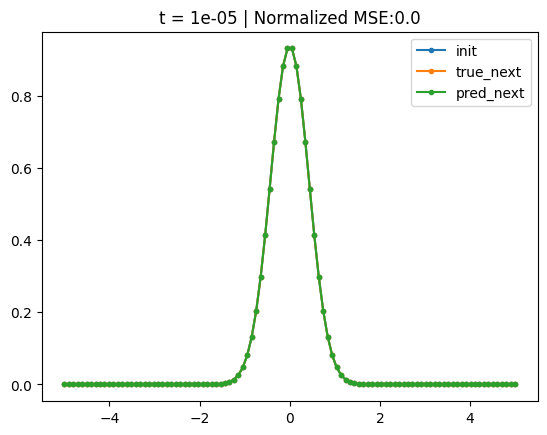

In [26]:
# Initial condition
plt.plot(Xfull,fp_1d_u0(Xfull),'.-',label='init')
# True next
plt.plot(Xfull,fp_1d_sol(final_t, Xfull),'.-',label='true_next')
# Predicted next
plt.plot(Xfull,u_next,'.-',label='pred_next')
# Plot settings 
nmse = mean_squared_error(u_next,fp_1d_sol(final_t, Xfull))/mean_squared_error(0*fp_1d_sol(final_t, Xfull),fp_1d_sol(final_t, Xfull))
plt.title('t = {} | Normalized MSE:{}'.format(h, round(nmse,7)))
plt.legend()
plt.show()

## Let's take small steps 

In [27]:
final_t = 0.5
masses = []
steps = int((final_t-0.1)//h)
delta = Xfull[1]-Xfull[0]
# Initialize at the initial condition
uprev = u0
for _ in range(steps):
    y_prev = jnp.concatenate((uprev,np.zeros((len(Xboundary)),)))
    #sol = jnp.linalg.solve(Kphiphi + nugget*R,y_prev)
    sol = jnp.linalg.solve(Kphiphi, y_prev)
    u_next = np.dot(Kphi.T,sol)
    mass = trap(u_next,delta)
    masses.append(mass)
    # update
    uprev = u_next[1:-1]

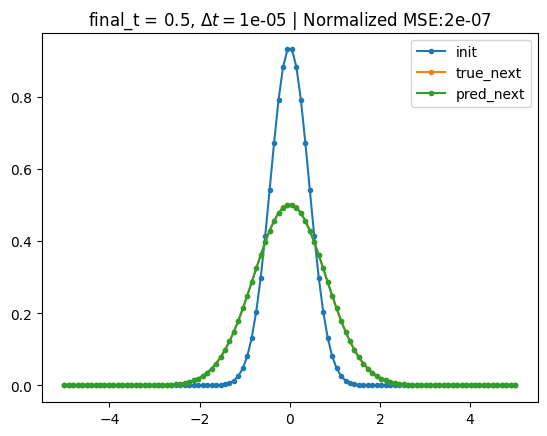

In [28]:
plt.figure()
# Initial condition
plt.plot(Xfull,fp_1d_u0(Xfull),'.-',label='init')
# True next
plt.plot(Xfull,fp_1d_sol(final_t, Xfull),'.-',label='true_next')
# Predicted next
plt.plot(Xfull,u_next,'.-',label='pred_next')
# Plot settings
nmse = mean_squared_error(u_next,fp_1d_sol(final_t, Xfull))/mean_squared_error(0*fp_1d_sol(final_t, Xfull),fp_1d_sol(final_t, Xfull))
plt.title('final_t = {}, $\Delta t = ${} | Normalized MSE:{}'.format(final_t, h, round(nmse,7)))
plt.legend()
plt.show()

### Mass conservation

In [29]:
masses[-1]

0.9997768307719392

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


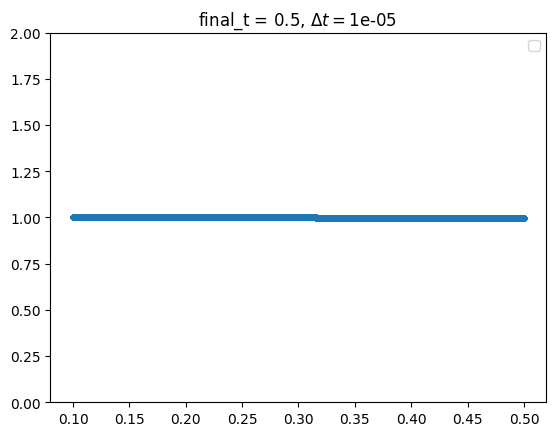

In [30]:
t_s = np.arange(0.1, final_t, h)[1:]
plt.figure()
# masses per time
plt.plot(t_s,masses,'.-',)
plt.ylim([0,2])
plt.title('final_t = {}, $\Delta t = ${} '.format(final_t, h))
plt.legend()
plt.show()

## Convergence

In [31]:
nugget = 0.

### Experiment 1

- $h = $`1e-1`
- `final_t`$ = 2$
- Collocation points increasing from $2^2$ to $2^{10}$

In [32]:
# Experiment 1.1 - L2-norms
L2_norms_1 = []
xrange = 2**np.arange(2,10)
for n in range(2,10):
    # X_full
    Xfull = np.linspace(-5,5,2**n+2)
    # Delta
    delta = Xfull[1]-Xfull[0]
    # X_{\partial\Omega}
    Xboundary = Xfull[[0,-1]]
    # X_\Omega
    Xomega = Xfull[1:-1]
    # u(X_\Omega,0)
    u0 = fp_1d_u0(Xomega)
    # Kernel lenght-scale
    k_param = 0.5
    # Time step
    h = 1e-1
    # Final t
    final_t = 2.5
    # No. of steps
    steps = int((final_t-0.1)//h)
    # Compute Kphiphi
    Kphiphi = Kphiphi_assembly(Xomega, Xboundary, h, k = kernel, k_param = k_param)
    # Regularizer for Kphiphi
    R = jnp.diag(jnp.diag(Kphiphi))
    # Compute Kphi againts Xfull which will be the test set
    Kphi = Kphi_assembly(Xfull, Xomega, Xboundary, h, k = kernel, k_param = k_param)
    
    uprev = u0
    for _ in range(steps):
        y_prev = jnp.concatenate((uprev,np.zeros((len(Xboundary)),)))
        sol = jnp.linalg.solve(Kphiphi + nugget*R, y_prev)
        u_next = np.dot(Kphi.T,sol)
        # update
        uprev = u_next[1:-1]
    
    # Numerical
    u_next = np.dot(Kphi.T,sol)
    # Analytical
    u_true = fp_1d_sol(final_t, Xfull)   
    # Differences
    f = np.abs(u_next - u_true)**2
    # Append L2 norm per iteration
    L2_norms_1.append(trap(f,delta))
    # Print L2 norm per iteration
    print(trap(f,delta))

0.4840127840209582
0.5318349805566507
0.5320244274410558
0.5320160406978383
0.5176432699859396
0.3334997206817163
0.11867602063965019
0.03251147630273806


- $h = $`1e-2`
- `final_t`$ = 2$
- Collocation points increasing from $2^2$ to $2^{10}$

In [33]:
# Experiment 1.2 - L2-norms
L2_norms_2 = []
xrange = 2**np.arange(2,10)
for n in range(2,10):
    # X_full
    Xfull = np.linspace(-5,5,2**n+2)
    # Delta
    delta = Xfull[1]-Xfull[0]
    # X_{\partial\Omega}
    Xboundary = Xfull[[0,-1]]
    # X_\Omega
    Xomega = Xfull[1:-1]
    # u(X_\Omega,0)
    u0 = fp_1d_u0(Xomega)
    # Kernel lenght-scale
    k_param = 0.5
    # Time step
    h = 1e-2
    # Final t
    final_t = 2.5
    # No. of steps
    steps = int((final_t-0.1)//h)
    # Compute Kphiphi
    Kphiphi = Kphiphi_assembly(Xomega, Xboundary, h, k = kernel, k_param = k_param)
    # Regularizer for Kphiphi
    R = jnp.diag(jnp.diag(Kphiphi))
    # Compute Kphi againts Xfull which will be the test set
    Kphi = Kphi_assembly(Xfull, Xomega, Xboundary, h, k = kernel, k_param = k_param)
    
    uprev = u0
    for _ in range(steps):
        y_prev = jnp.concatenate((uprev,np.zeros((len(Xboundary)),)))
        sol = jnp.linalg.solve(Kphiphi + nugget*R, y_prev)
        u_next = np.dot(Kphi.T,sol)
        # update
        uprev = u_next[1:-1]
    
    # Numerical
    u_next = np.dot(Kphi.T,sol)
    # Analytical
    u_true = fp_1d_sol(final_t, Xfull)   
    # Differences
    f = np.abs(u_next - u_true)**2
    # Append L2 norm per iteration
    L2_norms_2.append(trap(f,delta))
    # Print L2 norm per iteration
    print(trap(f,delta))

0.48401278388909624
0.5318349193337487
0.5306384376800619
0.41979235028054057
0.1719955123032026
0.04967976353132331
0.012864420344297474
0.003190457160288305


- $h = $`1e-3`
- `final_t`$ = 0.2$
- Collocation points increasing from $2^2$ to $2^{10}$

In [34]:
# Experiment 1.3 - L2-norms
L2_norms_3 = []
xrange = 2**np.arange(2,10)
for n in range(2,10):
    # X_full
    Xfull = np.linspace(-5,5,2**n+2)
    # Delta
    delta = Xfull[1]-Xfull[0]
    # X_{\partial\Omega}
    Xboundary = Xfull[[0,-1]]
    # X_\Omega
    Xomega = Xfull[1:-1]
    # u(X_\Omega,0)
    u0 = fp_1d_u0(Xomega)
    # Kernel lenght-scale
    k_param = 0.5
    # Time step
    h = 1e-3
    # Final t
    final_t = 2.5
    # No. of steps
    steps = int((final_t-0.1)//h)
    # Compute Kphiphi
    Kphiphi = Kphiphi_assembly(Xomega, Xboundary, h, k = kernel, k_param = k_param)
    # Regularizer for Kphiphi
    R = jnp.diag(jnp.diag(Kphiphi))
    # Compute Kphi againts Xfull which will be the test set
    Kphi = Kphi_assembly(Xfull, Xomega, Xboundary, h, k = kernel, k_param = k_param)
    
    uprev = u0
    for _ in range(steps):
        y_prev = jnp.concatenate((uprev,np.zeros((len(Xboundary)),)))
        sol = jnp.linalg.solve(Kphiphi + nugget*R, y_prev)
        u_next = np.dot(Kphi.T,sol)
        # update
        uprev = u_next[1:-1]
    
    # Numerical
    u_next = np.dot(Kphi.T,sol)
    # Analytical
    u_true = fp_1d_sol(final_t, Xfull)   
    # Differences
    f = np.abs(u_next - u_true)**2
    # Append L2 norm per iteration
    L2_norms_3.append(trap(f,delta))
    # Print L2 norm per iteration
    print(trap(f,delta))

0.4840127048978171
0.5318067472264195
0.48316456797364554
0.15144756817652277
0.027028527431421593
0.00563321771534434
0.0013259604279984103
0.00032078909160952165


- $h = $`1e-4`
- `final_t`$ = 0.2$
- Collocation points increasing from $2^2$ to $2^{10}$

In [35]:
# Experiment 1.4 - L2-norms
L2_norms_4 = []
xrange = 2**np.arange(2,10)
for n in range(2,10):
    # X_full
    Xfull = np.linspace(-5,5,2**n+2)
    # Delta
    delta = Xfull[1]-Xfull[0]
    # X_{\partial\Omega}
    Xboundary = Xfull[[0,-1]]
    # X_\Omega
    Xomega = Xfull[1:-1]
    # u(X_\Omega,0)
    u0 = fp_1d_u0(Xomega)
    # Kernel lenght-scale
    k_param = 0.5
    # Time step
    h = 1e-4
    # Final t
    final_t = 2.5
    # No. of steps
    steps = int((final_t-0.1)//h)
    # Compute Kphiphi
    Kphiphi = Kphiphi_assembly(Xomega, Xboundary, h, k = kernel, k_param = k_param)
    # Regularizer for Kphiphi
    R = jnp.diag(jnp.diag(Kphiphi))
    # Compute Kphi againts Xfull which will be the test set
    Kphi = Kphi_assembly(Xfull, Xomega, Xboundary, h, k = kernel, k_param = k_param)
    
    uprev = u0
    for _ in range(steps):
        y_prev = jnp.concatenate((uprev,np.zeros((len(Xboundary)),)))
        sol = jnp.linalg.solve(Kphiphi + nugget*R, y_prev)
        u_next = np.dot(Kphi.T,sol)
        # update
        uprev = u_next[1:-1]
    
    # Numerical
    u_next = np.dot(Kphi.T,sol)
    # Analytical
    u_true = fp_1d_sol(final_t, Xfull)   
    # Differences
    f = np.abs(u_next - u_true)**2
    # Append L2 norm per iteration
    L2_norms_4.append(trap(f,delta))
    # Print L2 norm per iteration
    print(trap(f,delta))

0.4840126194666929
0.531779759472247
0.46171308190476595
0.10195696382701298
0.009697141536637484
0.001029591999043271
0.00016241219430579868
3.3984941764191274e-05


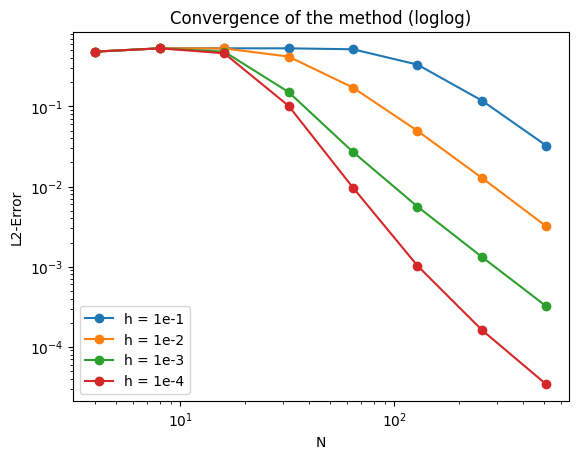

In [36]:
# One plot
plt.loglog(xrange,L2_norms_1,label = 'h = 1e-1', marker = 'o')
plt.loglog(xrange,L2_norms_2,label = 'h = 1e-2', marker = 'o')
plt.loglog(xrange,L2_norms_3,label = 'h = 1e-3', marker = 'o')
plt.loglog(xrange,L2_norms_4,label = 'h = 1e-4', marker = 'o')
plt.xlabel('N')
plt.ylabel('L2-Error')
plt.legend()
plt.title('Convergence of the method (loglog)')
plt.show()

### Experiment 2

- $h$ decreasing from `1e-2` to `1e-5`
- `final_t`$ = 0.5$
- Collocation points = $2^5$

In [37]:
# Experiment 2.1 - L2-norms
L2_norms_1 = []
xrange = 10.0**(-np.arange(2,6))
for n in range(2,6):
    # X_full
    Xfull = np.linspace(-5,5,2**5+2)
    # Delta
    delta = Xfull[1]-Xfull[0]
    # X_{\partial\Omega}
    Xboundary = Xfull[[0,-1]]
    # X_\Omega
    Xomega = Xfull[1:-1]
    # u(X_\Omega,0)
    u0 = fp_1d_u0(Xomega)
    # Kernel lenght-scale
    k_param = 0.5
    # Time step
    h = 10**(-n)
    # Final t
    final_t = 2.5
    # No. of steps
    steps = int((final_t-0.1)//h)
    # Compute Kphiphi
    Kphiphi = Kphiphi_assembly(Xomega, Xboundary, h, k = kernel, k_param = k_param)
    # Regularizer for Kphiphi
    R = jnp.diag(jnp.diag(Kphiphi))
    # Compute Kphi againts Xfull which will be the test set
    Kphi = Kphi_assembly(Xfull, Xomega, Xboundary, h, k = kernel, k_param = k_param)
    
    uprev = u0
    for _ in range(steps):
        y_prev = jnp.concatenate((uprev,np.zeros((len(Xboundary)),)))
        sol = jnp.linalg.solve(Kphiphi + nugget*R, y_prev)
        u_next = np.dot(Kphi.T,sol)
        # update
        uprev = u_next[1:-1]
    
    # Numerical
    u_next = np.dot(Kphi.T,sol)
    # Analytical
    u_true = fp_1d_sol(final_t, Xfull)   
    # Differences
    f = np.abs(u_next - u_true)**2
    # Append L2 norm per iteration
    L2_norms_1.append(trap(f,delta))
    # Print L2 norm per iteration
    print(trap(f,delta))

0.41979235028054057
0.15144756817652277
0.10195696382701298
0.09666776579980127


- $h$ decreasing from `1e-2` to `1e-5`
- `final_t`$= 0.5$
- Collocation points = $2^6$

In [38]:
# Experiment 2.2 - L2-norms
L2_norms_2 = []
xrange = 10.0**(-np.arange(2,6))
for n in range(2,6):
    # X_full
    Xfull = np.linspace(-5,5,2**6+2)
    # Delta
    delta = Xfull[1]-Xfull[0]
    # X_{\partial\Omega}
    Xboundary = Xfull[[0,-1]]
    # X_\Omega
    Xomega = Xfull[1:-1]
    # u(X_\Omega,0)
    u0 = fp_1d_u0(Xomega)
    # Kernel lenght-scale
    k_param = 0.5
    # Time step
    h = 10**(-n)
    # Final t
    final_t = 2.5
    # No. of steps
    steps = int((final_t-0.1)//h)
    # Compute Kphiphi
    Kphiphi = Kphiphi_assembly(Xomega, Xboundary, h, k = kernel, k_param = k_param)
    # Regularizer for Kphiphi
    R = jnp.diag(jnp.diag(Kphiphi))
    # Compute Kphi againts Xfull which will be the test set
    Kphi = Kphi_assembly(Xfull, Xomega, Xboundary, h, k = kernel, k_param = k_param)
    
    uprev = u0
    for _ in range(steps):
        y_prev = jnp.concatenate((uprev,np.zeros((len(Xboundary)),)))
        sol = jnp.linalg.solve(Kphiphi + nugget*R, y_prev)
        u_next = np.dot(Kphi.T,sol)
        # update
        uprev = u_next[1:-1]
    
    # Numerical
    u_next = np.dot(Kphi.T,sol)
    # Analytical
    u_true = fp_1d_sol(final_t, Xfull)   
    # Differences
    f = np.abs(u_next - u_true)**2
    # Append L2 norm per iteration
    L2_norms_2.append(trap(f,delta))
    # Print L2 norm per iteration
    print(trap(f,delta))

0.1719955123032026


0.027028527431421593
0.009697141536637484
0.00793224479591271


- $h$ decreasing from `1e-2` to `1e-5`
- `final_t`$= 0.5$
- Collocation points = $2^7$

In [39]:
# Experiment 2.3 - L2-norms
L2_norms_3 = []
xrange = 10.0**(-np.arange(2,6))
for n in range(2,6):
    # X_full
    Xfull = np.linspace(-5,5,2**7+2)
    # Delta
    delta = Xfull[1]-Xfull[0]
    # X_{\partial\Omega}
    Xboundary = Xfull[[0,-1]]
    # X_\Omega
    Xomega = Xfull[1:-1]
    # u(X_\Omega,0)
    u0 = fp_1d_u0(Xomega)
    # Kernel lenght-scale
    k_param = 0.5
    # Time step
    h = 10**(-n)
    # Final t
    final_t = 2.5
    # No. of steps
    steps = int((final_t-0.1)//h)
    # Compute Kphiphi
    Kphiphi = Kphiphi_assembly(Xomega, Xboundary, h, k = kernel, k_param = k_param)
    # Regularizer for Kphiphi
    R = jnp.diag(jnp.diag(Kphiphi))
    # Compute Kphi againts Xfull which will be the test set
    Kphi = Kphi_assembly(Xfull, Xomega, Xboundary, h, k = kernel, k_param = k_param)
    
    uprev = u0
    for _ in range(steps):
        y_prev = jnp.concatenate((uprev,np.zeros((len(Xboundary)),)))
        sol = jnp.linalg.solve(Kphiphi + nugget*R, y_prev)
        u_next = np.dot(Kphi.T,sol)
        # update
        uprev = u_next[1:-1]
    
    # Numerical
    u_next = np.dot(Kphi.T,sol)
    # Analytical
    u_true = fp_1d_sol(final_t, Xfull)   
    # Differences
    f = np.abs(u_next - u_true)**2
    # Append L2 norm per iteration
    L2_norms_3.append(trap(f,delta))
    # Print L2 norm per iteration
    print(trap(f,delta))

0.04967976353132331
0.00563321771534434
0.001029591999043271
0.0005672058987458489


- $h$ decreasing from `1e-2` to `1e-5`
- `final_t`$= 0.5$
- Collocation points = $2^8$

In [40]:
# Experiment 2.4 - L2-norms
L2_norms_4 = []
xrange = 10.0**(-np.arange(2,6))
for n in range(2,6):
    # X_full
    Xfull = np.linspace(-5,5,2**8+2)
    # Delta
    delta = Xfull[1]-Xfull[0]
    # X_{\partial\Omega}
    Xboundary = Xfull[[0,-1]]
    # X_\Omega
    Xomega = Xfull[1:-1]
    # u(X_\Omega,0)
    u0 = fp_1d_u0(Xomega)
    # Kernel lenght-scale
    k_param = 0.5
    # Time step
    h = 10**(-n)
    # Final t
    final_t = 2.5
    # No. of steps
    steps = int((final_t-0.1)//h)
    # Compute Kphiphi
    Kphiphi = Kphiphi_assembly(Xomega, Xboundary, h, k = kernel, k_param = k_param)
    # Regularizer for Kphiphi
    R = jnp.diag(jnp.diag(Kphiphi))
    # Compute Kphi againts Xfull which will be the test set
    Kphi = Kphi_assembly(Xfull, Xomega, Xboundary, h, k = kernel, k_param = k_param)
    
    uprev = u0
    for _ in range(steps):
        y_prev = jnp.concatenate((uprev,np.zeros((len(Xboundary)),)))
        sol = jnp.linalg.solve(Kphiphi + nugget*R, y_prev)
        u_next = np.dot(Kphi.T,sol)
        # update
        uprev = u_next[1:-1]
    
    # Numerical
    u_next = np.dot(Kphi.T,sol)
    # Analytical
    u_true = fp_1d_sol(final_t, Xfull)   
    # Differences
    f = np.abs(u_next - u_true)**2
    # Append L2 norm per iteration
    L2_norms_4.append(trap(f,delta))
    # Print L2 norm per iteration
    print(trap(f,delta))

0.012864420344297474


0.0013259604279984103
0.00016241219430579868
4.5974306503454416e-05


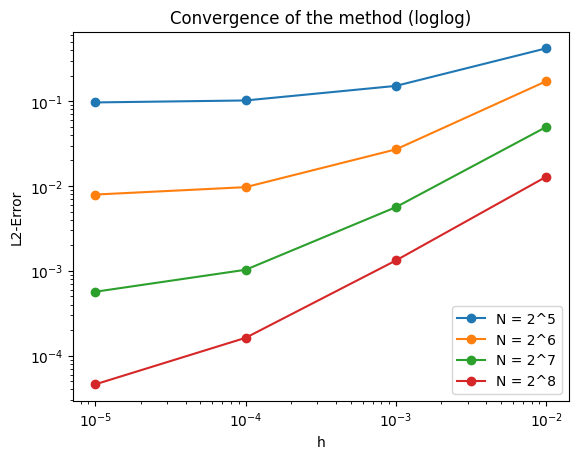

In [41]:
# One plot
plt.loglog(xrange,L2_norms_1,label = 'N = 2^5', marker = 'o')
plt.loglog(xrange,L2_norms_2,label = 'N = 2^6', marker = 'o')
plt.loglog(xrange,L2_norms_3,label = 'N = 2^7', marker = 'o')
plt.loglog(xrange,L2_norms_4,label = 'N = 2^8', marker = 'o')
plt.xlabel('h')
plt.ylabel('L2-Error')
plt.legend()
plt.title('Convergence of the method (loglog)')
plt.show()